In [1]:
model_path = 'yolo3_trained_trial_1_@_20230601_inf.h5'

classes_path = './yolo_classes.txt'
anchors_path = './yolo_anchors.txt'

import os
import colorsys
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw
from IPython.display import display
from timeit import default_timer as timer
from keras.models import load_model
from keras import backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

def letterbox_image(image, size):
    iw, ih = image.size
    w, h = size
    scale = min(w/iw, h/ih)
    nw = int(iw*scale)
    nh = int(ih*scale)
    image = image.resize((nw,nh), Image.BICUBIC)
    new_image = Image.new('RGB', size, (128,128,128))
    new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    return new_image

def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=20,
              score_threshold=.6,
              iou_threshold=.5):
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # default setting
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)
    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        # TODO: use keras backend instead of tf.
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)
    return boxes_, scores_, classes_

def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores

def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))
    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])
    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[...,::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[...,::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])
    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale
    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])
    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes

class YOLO:
    _defaults = {
        "model_path": model_path,
        "anchors_path": anchors_path,
        "classes_path": classes_path,
        "score" : 0.2,
        "iou" : 0.4,
        "model_image_size" : (416, 416),
        "gpu_num" : 0, # Only CPU
    }

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.yolo_model = self.generate()
        self.boxes, self.scores, self.classes = self.get_bbox()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'
        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        self.yolo_model = load_model(model_path, compile=False)
        print('{} model, anchors, and classes loaded.'.format(model_path))
        return self.yolo_model

    def get_bbox(self):
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.
        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def draw_image(self, image):
        start = timer()
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')
        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                # K.learning_phase(): 0
            })
        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))
        thickness = (image.size[0] + image.size[1]) // 300
        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]
            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label)
            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0))
            del draw
        end = timer()
        print(end - start)
        return image

    def get_score(self, image):
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
        feed_data = {
            self.yolo_model.input: image_data,
            self.input_image_shape: [image.size[1], image.size[0]],
        }
        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes], feed_dict=feed_data)
        '''
        print('Found {} boxes for {}'.format(len(out_boxes), image))
        print("out_boxes:", out_boxes)
        print("out_scores", out_scores)
        print("out_classes", out_classes)
        '''
        return out_scores

Instructions for updating:
Colocations handled automatically by placer.
yolo3_trained_trial_1_@_20230601_inf.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for img
Gcooter 0.94 (212, 302) (527, 568)
3.039199400000001


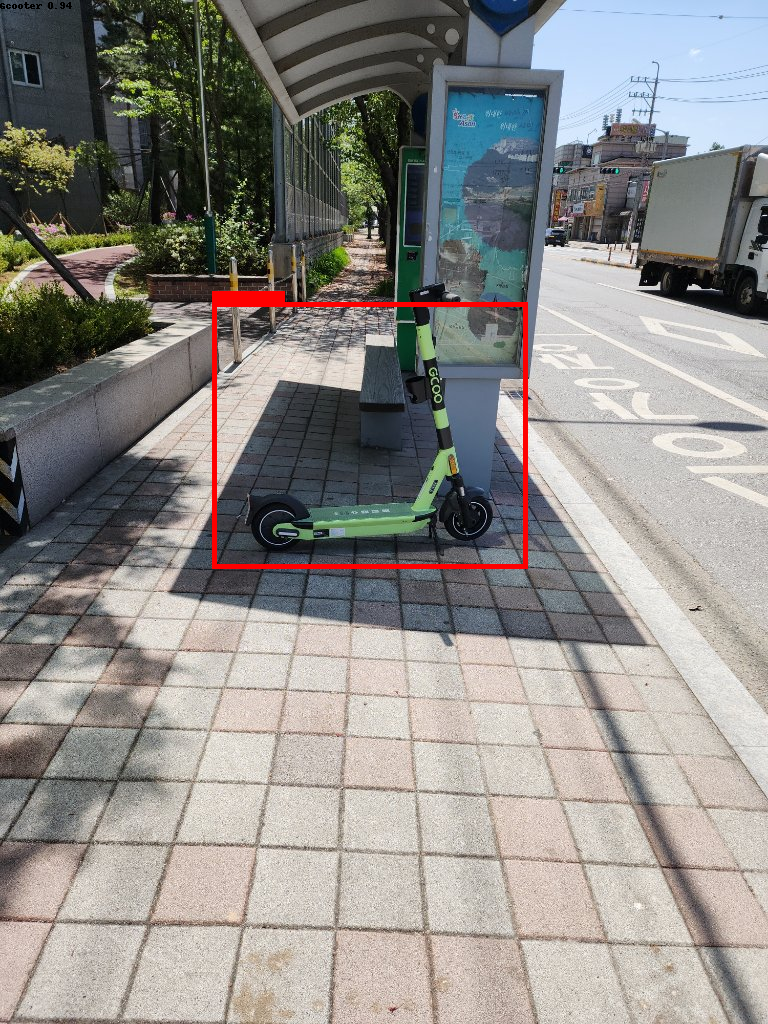

{'gcooter_detected': True}


In [2]:
# Only CPU 약 30초 걸림 @ 노트북

yolo = YOLO()

img_file = "./image4test.jpg"
image = Image.open(img_file)
display(yolo.draw_image(image))
info_detected = yolo.get_score(image)
detection_score = 0
if len(info_detected) != 0:
    detection_score = np.max(info_detected)
# if Gcooter is detected
if detection_score > 0.20:
    json_data = { "gcooter_detected" : True }
else:
    json_data = { "gcooter_detected" : False }
print(json_data)

In [3]:
# Only CPU 약 4분 걸림 @ 노트북

import os

yolo = YOLO()

count_true_positive = 0
count_true_negative = 0
count_false_positive = 0
count_false_negative = 0

def isGcooter(img_file):
    image = Image.open(img_file)
    info_detected = yolo.get_score(image)
    detection_score = 0
    if len(info_detected) != 0:
        detection_score = np.max(info_detected)
    # if Gcooter is detected
    if detection_score > 0.20:
        return True
    else:
        return False

folder_path = "./validation/gcooter_detected = true"
file_list = []

print("\nOutput:", folder_path)

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        file_list.append(file_path)

for file_path in file_list:
    if isGcooter(file_path):
        count_true_positive = count_true_positive + 1
    else:
        count_true_negative = count_true_negative + 1

print("# of Gcooter-positive:", count_true_positive)
print("# of Gcooter-negative:", count_true_negative)

folder_path = "./validation/gcooter_detected = false"
file_list = []

print("\nOutput:", folder_path)

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        file_list.append(file_path)

for file_path in file_list:
    if isGcooter(file_path):
        count_false_positive = count_false_positive + 1
    else:
        count_false_negative = count_false_negative + 1

print("# of Gcooter-positive:", count_false_positive)
print("# of Gcooter-negative:", count_false_negative)

accuracy = (count_true_positive+count_false_negative)/2
print("\nAccuracy: (TP+TN)% / 2 =", accuracy)

yolo3_trained_trial_1_@_20230601_inf.h5 model, anchors, and classes loaded.

Output: ./validation/gcooter_detected = true
# of Gcooter-positive: 70
# of Gcooter-negative: 30

Output: ./validation/gcooter_detected = false
# of Gcooter-positive: 1
# of Gcooter-negative: 99

Accuracy: (TP+TN)% / 2 = 84.5
